# 3. Profit Curves - Real World Cost Sensitivity

**Goal:** Apply realistic financial costs to the credit default predictions.

**Economics (Hypothetical but Realistic):**
- **True Negative (Good Payer):** +$1,000 (Interest income)
- **False Negative (Default):** -$5,000 (Principal loss)
- **False Positive (Rejection):** -$0 (Opportunity cost is baked into the delta)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

df = pd.read_excel('../data/raw/credit_card_default.xls', header=1)
df.rename(columns={'default payment next month': 'target'}, inplace=True)

X = df.drop(['ID', 'target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_test)[:, 1]

## 1. Profit Calculation Function

In [2]:
cost_matrix = {
    'TN': 1000,   # Earn interest
    'FP': 0,      # Reject good customer (opportunity cost set to 0 to keep math simple)
    'FN': -5000,  # Huge loss
    'TP': 0       # Reject bad customer (avoided loss, no immediate profit)
}

def calculate_profit(y_true, y_probs, threshold):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    profit = (tn * cost_matrix['TN']) + (fp * cost_matrix['FP']) + \
             (fn * cost_matrix['FN']) + (tp * cost_matrix['TP'])
    return profit

thresholds = np.linspace(0, 1, 100)
profits = [calculate_profit(y_test, y_prob, t) for t in thresholds]

## 2. Optimization Curve

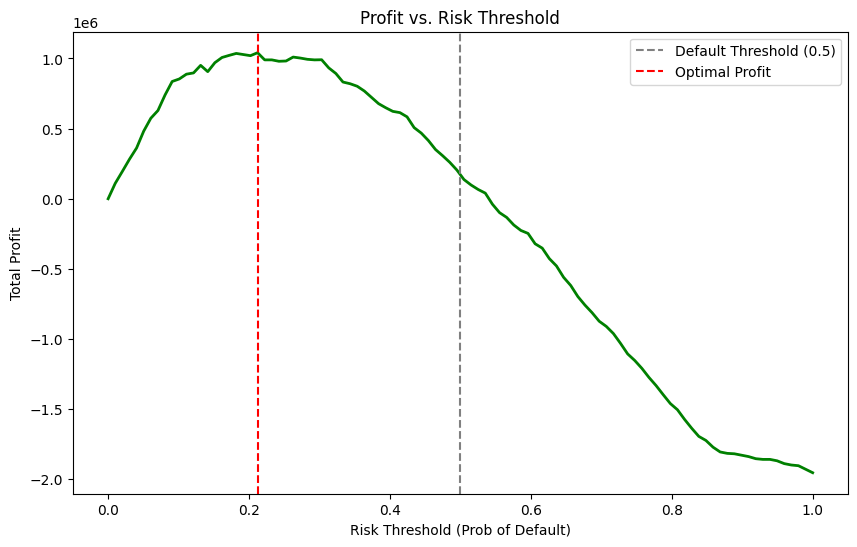

Max Profit: $1,041,000
Optimal Threshold: 0.21


In [3]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, lw=2, color='green')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.axvline(x=thresholds[np.argmax(profits)], color='red', linestyle='--', label='Optimal Profit')
plt.title('Profit vs. Risk Threshold')
plt.xlabel('Risk Threshold (Prob of Default)')
plt.ylabel('Total Profit')
plt.legend()
plt.show()

print(f"Max Profit: ${np.max(profits):,.0f}")
print(f"Optimal Threshold: {thresholds[np.argmax(profits)]:.2f}")